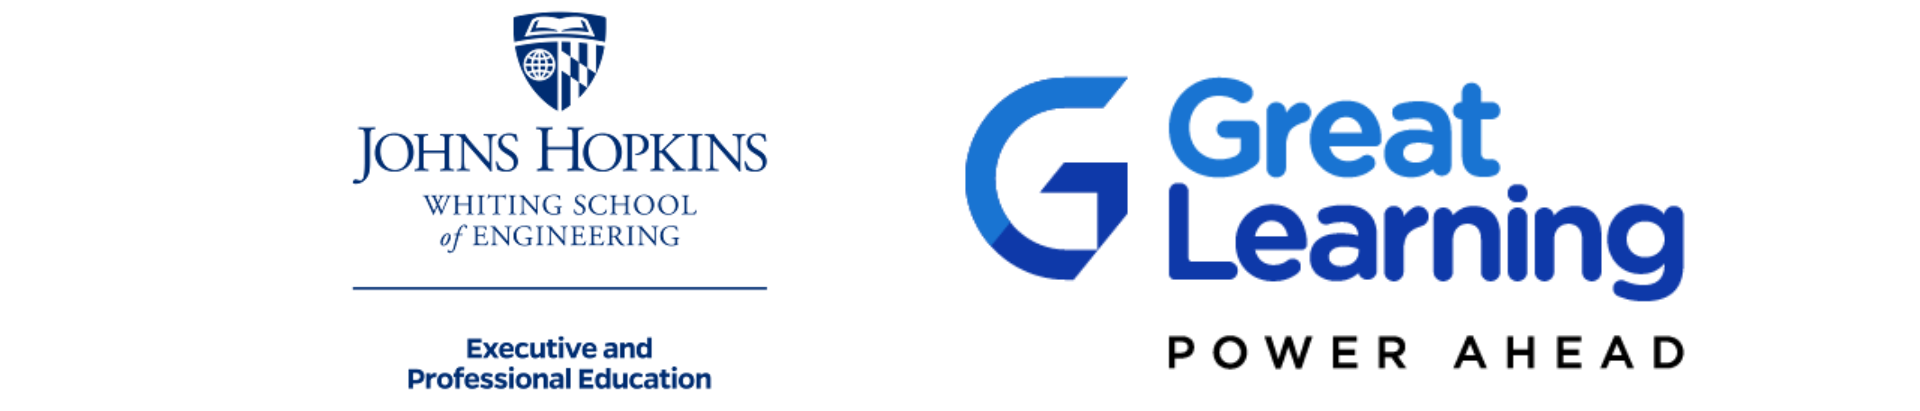

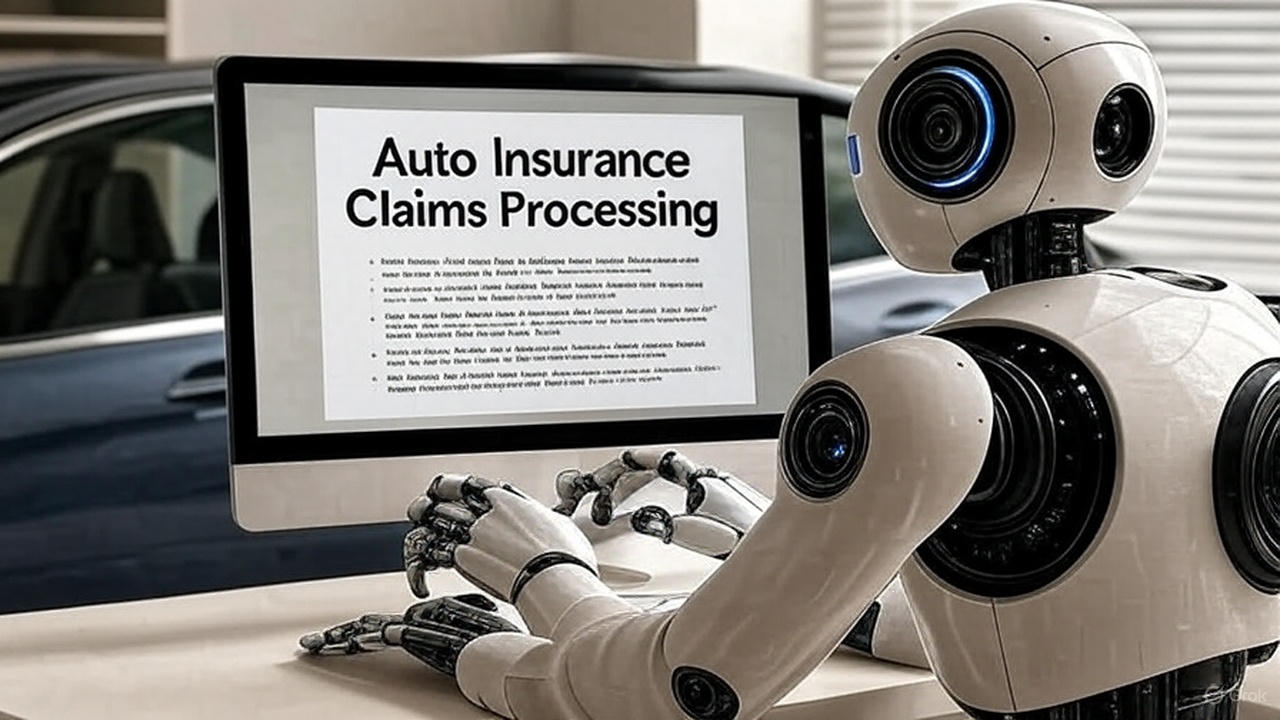

# Learning Objective

- Implement a RAG-powered Agentic application using the **smolagents** package, showcasing the integration of a Knowledge Base, Retriever and Generator within a single agent system.

# Business Case: Auto Insurance Claims Processing

In the auto insurance industry, the claim process is predominantly manual. Claims executives manually parse invoices to extract key details, cross-reference vendor contracts to verify terms and compliance, and validate payments against policy stipulations. This process requires extensive review of complex policy documents, relying heavily on the executive's subject matter expertise and judgment to adjudicate claims.


## Problem Scenario

Due to its manual nature, claims processing is susceptible to delays. Policy documents are extensive and updated regularly, making it challenging for human operators to stay current with all changes. Manual errors, such as rejecting claims on invalid grounds, can lead to client frustration and dissatisfaction. Consequently, these inefficiencies lead to prolonged processing times, higher operational costs(in longterm), and potential reputational damage.


## Proposed Solution

The solution proposed is to develop an automated insurance claims processing system powered by Agentic Retrieval-Augmented Generation (Agentic RAG) capabilities. This solution embed single AI-agents with a knolwdge base into a RAG pipeline. The system retrieves relevant policy details, integrates them with user claim data, and generates adjudication recommendations while ensuring compliance with regulatory requirements. The advantages include time savings, long-term cost reduction, and more.

## Why AgenticRAG Over Traditional RAG ?

Traditional RAG systems rely on static workflows, limiting their adaptability for complex, multi-step tasks. AgenticRAG, however, uses agentic design patterns - **reflection**, **planning**, **tool use**, and **collaboration** to dynamically manage retrieval, refine context, and adapt workflows. With flexible operational structures, from sequential to collaborative, AgenticRAG offers superior flexibility, scalability, and context-awareness, making it ideal for dynamic applications like automated claims processing.

In [ ]:
## setup
!pip install -q openai==1.101.0 \
                smolagents[toolkit]==1.21.2 \
                chromadb==0.6.3 \
                posthog==3.0.2 \
                PyPDF2==3.0.1

## posthog is a supporting library for ChromaDB

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 49.3 MB/s 

## Execution Plan

The notebook implements an agentic workflow to process auto insurance claims using the `smolagents` package and `ChromaDB` for Retrieval-Augmented Generation (RAG). The execution workflow consists of the following steps:
1. Parse claim details from a JSON file.

2. Generate queries to retrieve relevant policy sections.

3. Retrieve policy text from a ChromaDB vector store.

4. Evaluate coverage and generate a recommendation.

5. Produce a final claim decision.

The **policy document** `policy.pdf`  is provided.

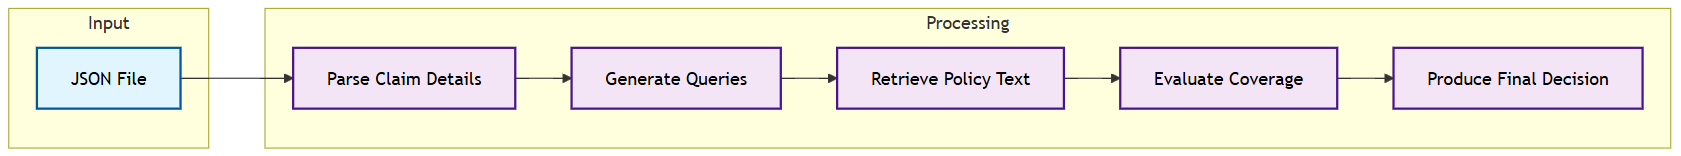

## Imports & Environment Setup

In [ ]:
# imports
import json
import os
import time
import re
from typing import List, Optional

import chromadb
import PyPDF2
from google.colab import userdata
from pydantic import BaseModel, Field
from sentence_transformers import SentenceTransformer

from smolagents import (
    tool,
    ToolCallingAgent,
    OpenAIServerModel,
    PromptTemplates,
    PlanningPromptTemplate,
    ManagedAgentPromptTemplate,
    FinalAnswerPromptTemplate,
)

In [ ]:
# Set environment variables
openai_api_key = userdata.get('openai_api_key')
os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ['OPENAI_BASE_URL'] = "https://aibe.mygreatlearning.com/openai/v1"

## LLM
**GPT-4o-mini** will be used as the LLM.

In [ ]:
## LLM Setup
model = OpenAIServerModel(
    model_id="gpt-4o-mini",
    api_base="https://aibe.mygreatlearning.com/openai/v1",
    api_key=openai_api_key,
)

## Embedding Model

The 'all-MiniLM-L6-v2' pretrained embedding model will be used for converting sentences and words into numerical (vectors).

In [ ]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Schema
Let us begin by defining our schema object class to hold all the items in the system's workflow that we want to store.

In [ ]:
class ClaimInfo(BaseModel):
    """Extracted insurance claim information."""
    claim_number: str
    policy_number: str
    claimant_name: str
    date_of_loss: str
    loss_description: str
    estimated_repair_cost: float
    vehicle_details: Optional[str] = None

In [ ]:
class PolicyQueries(BaseModel):
    queries: List[str] = Field(
        default_factory=list,
        description="A list of query strings to retrieve relevant policy sections."
    )

In [ ]:
class PolicyRecommendation(BaseModel):
    """Policy recommendation regarding a given claim."""
    policy_section: str = Field(..., description="The policy section or clause that applies.")
    recommendation_summary: str = Field(..., description="A concise summary of coverage determination.")
    deductible: Optional[float] = Field(None, description="The applicable deductible amount.")
    settlement_amount: Optional[float] = Field(None, description="Recommended settlement payout.")

In [ ]:
class ClaimDecision(BaseModel):
    claim_number: str
    covered: bool
    deductible: float
    recommended_payout: float
    notes: Optional[str] = None

## ChromaDB Setup
Setting up the Chroma vector database client and collection for storing and retrieving policy document.

In [ ]:
#Initialize ChromaDB and creating collection
chroma_client = chromadb.Client()
collection_name = "auto_insurance_policy"

try:
    collection = chroma_client.get_or_create_collection(name=collection_name)
except Exception as e:
    print(f"Error creating collection: {e}")
    collection = chroma_client.create_collection(name=collection_name)

The policy document will be uploaded and then divided into sections called **chunks**.

Here, each page is considered a chunk.

Finally, the chunks will be vectorized using an embedding model before being inserted into our vector database - ChromaDB.

In [ ]:
# Do make sure the file is uploaded in the below path
policy_file_path = "/content/policy.pdf"

with open(policy_file_path, "rb") as f:
    reader = PyPDF2.PdfReader(f)
    policy_text = ""
    for page in reader.pages:
        policy_text += page.extract_text()

# Split policy text into chunks (e.g., by page)
policy_chunks = policy_text.split("\n\n")
chunk_ids = [f"chunk_{i}" for i in range(len(policy_chunks))]
chunk_embeddings = embedder.encode(policy_chunks)

# Add chunks to ChromaDB
collection.add(
    documents=policy_chunks,
    embeddings=chunk_embeddings,
    ids=chunk_ids
)

## Define Tools

Define custom tools for parsing claims, generating queries, retrieving policy text, generating recommendations, and finalizing decisions.

### Tool 1: Parse Claim

Parse the claim JSON file into a `ClaimInfo` object.

In [ ]:
@tool
def parse_claim(file_path: str) -> str:
    """
    Parse a claim JSON file and return structured ClaimInfo data.

    Args:
        file_path (str): Path to the JSON file containing claim data.
    """
    print("[INSIDE TOOL]: parse_claim")
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
        claim_info = ClaimInfo.model_validate(data)
        return claim_info.model_dump_json()
    except Exception as e:
        return f"Error parsing claim: {str(e)}"

### Tool 2: Generate Policy Queries

Generate 3-5 queries to retrieve relevant policy sections based on claim details.

In [ ]:
@tool
def generate_policy_queries(claim_info_json: str) -> str:
    """
    Generate queries to retrieve relevant policy sections based on claim info.

    Args:
        claim_info_json (str): JSON string of ClaimInfo data.
    """
    print("[INSIDE TOOL]: generate_policy_queries")
    prompt = f"""
    Analyze the following auto insurance claim to identify 3-5 key policy sections to consult:
    - Focus on collision coverage, liability, deductibles, and relevant exclusions or endorsements.
    - Claim Data: {claim_info_json}
    - Return a JSON object with a 'queries' field containing a list of strings, e.g., {{"queries": ["query1", "query2", "query3"]}}. Do not include metadata fields.
    """
    max_retries = 5
    retry_delay = 1  # Initial delay in seconds
    for attempt in range(max_retries):
        try:
            messages = [{"role": "user", "content": prompt}]
            response = model(messages)
            print(f"[DEBUG]: generate_policy_queries response: {response}")
            # Handle ChatMessage object
            response_content = response.content if hasattr(response, 'content') else str(response)
            # Validate and transform response
            try:
                result = json.loads(response_content)
                if isinstance(result, dict) and "queries" in result:
                    queries = result["queries"]
                    if isinstance(queries, list) and all(isinstance(q, str) for q in queries):
                        return json.dumps(result)
                    elif isinstance(queries, list):
                        # Transform list of dicts to list of strings, ignoring metadata
                        queries = [q["query"] if isinstance(q, dict) and "query" in q else str(q) for q in queries]
                        return json.dumps({"queries": queries})
                return json.dumps({"queries": []})  # Fallback empty queries
            except json.JSONDecodeError:
                return f"Error: Invalid JSON response from model: {response_content}"
        except Exception as e:
                return f"Error generating policy queries: {str(e)}"

### Tool 3: Retrieve Policy Text

Retrieve relevant policy sections from ChromaDB using the generated queries.

In [ ]:
@tool
def retrieve_policy_text(queries_json: str) -> str:
    """
    Retrieve policy text from ChromaDB based on queries.

    Args:
        queries_json (str): JSON string of PolicyQueries.
    """
    print("[INSIDE TOOL]: retrieve_policy_text")
    try:
        # Parse and validate queries_json
        print(f"[DEBUG]: Input queries_json: {queries_json}")
        queries_data = json.loads(queries_json)
        if not isinstance(queries_data, dict) or "queries" not in queries_data:
            return f"Error: Invalid queries_json format, expected {'queries': [...]}, got {queries_json}"

        queries = queries_data["queries"]
        if not isinstance(queries, list):
            return f"Error: Queries field must be a list, got {type(queries)}"

        # Handle queries as dictionaries or strings
        query_strings = []
        for q in queries:
            if isinstance(q, dict) and "query" in q:
                query_strings.append(q["query"])
            elif isinstance(q, str):
                query_strings.append(q)
            else:
                print(f"[DEBUG]: Skipping invalid query item: {q}")

        # Validate with PolicyQueries
        queries = PolicyQueries(queries=query_strings)

        policy_texts = []
        for query in queries.queries:
            print(f"[CHROMA SEARCH]: Query: {query}")
            query_embedding = embedder.encode([query])[0]
            results = collection.query(
                query_embeddings=[query_embedding],
                n_results=2  # Reduced to 2 to save tokens
            )
            relevant_chunks = results['documents'][0]
            policy_texts.extend(relevant_chunks)

        return "\n\n".join(policy_texts)
    except json.JSONDecodeError:
        return f"Error: Invalid JSON in queries_json"
    except Exception as e:
        return f"Error retrieving policy text: {str(e)}"

### Tool 4 : Generate Recommendation

Evaluate the claim against retrieved policy text to produce a recommendation.

In [ ]:
@tool
def generate_recommendation(claim_info_json: str, policy_text: str) -> str:
    """
    Generate a policy recommendation based on claim info and retrieved policy text.

    Args:
        claim_info_json (str): JSON string of ClaimInfo data.
        policy_text (str): Retrieved policy text.
    """
    print("[INSIDE TOOL]: generate_recommendation")
    prompt = f"""
    Evaluate the following auto insurance claim against the policy text:
    - Determine if the collision is covered, the deductible, settlement amount, and applicable policy section.
    - Claim Info: {claim_info_json}
    - Policy Text: {policy_text}
    - Return a JSON object matching the following schema:
      {{
        "policy_section": "str", // The specific policy section or clause (e.g., 'Exclusions', 'Collision Coverage')
        "recommendation_summary": "str", // Concise summary of coverage determination
        "deductible": float or null, // Applicable deductible amount, if any
        "settlement_amount": float or null // Recommended payout, if any
      }}
    - Example:
      {{
        "policy_section": "Exclusions",
        "recommendation_summary": "Claim denied due to business use exclusion",
        "deductible": null,
        "settlement_amount": 0.0
      }}
    - Do not use fields like 'recommendation', 'coverage_evaluation', or 'reason'.
    """
    max_retries = 5
    retry_delay = 1  # Initial delay in seconds
    for attempt in range(max_retries):
        try:
            messages = [{"role": "user", "content": prompt}]
            response = model(messages)
            print(f"[DEBUG]: generate_recommendation response: {response}")
            # Handle ChatMessage object
            response_content = response.content if hasattr(response, 'content') else str(response)
            # Validate response
            try:
                result = json.loads(response_content)
                PolicyRecommendation.model_validate(result)  # Ensure it matches schema
                return response_content
            except json.JSONDecodeError:
                return f"Error: Invalid JSON response from model: {response_content}"
            except Exception as e:
                return f"Error: Invalid recommendation format: {str(e)}"
        except Exception as e:
                return f"Error generating recommendation: {str(e)}"

### Tool 5:  Finalize Decision

Convert the recommendation into a final `ClaimDecision`.

In [ ]:
@tool
def finalize_decision(claim_info_json: str, recommendation_json: str) -> str:
    """
    Finalize the claim decision based on the recommendation.

    Args:
        claim_info_json (str): JSON string of ClaimInfo data.
        recommendation_json (str): JSON string of PolicyRecommendation.
    """
    print("[INSIDE TOOL]: finalize_decision")
    print(f"[DEBUG]: recommendation_json: {recommendation_json}")
    try:
        claim_info = ClaimInfo.model_validate_json(claim_info_json)
        # Parse recommendation_json and handle unexpected fields
        rec_data = json.loads(recommendation_json)
        if not isinstance(rec_data, dict):
            return f"Error: recommendation_json must be a JSON object, got {type(rec_data)}"

        # Map unexpected fields to PolicyRecommendation schema
        if "policy_section" not in rec_data:
            # Extract policy section from text (e.g., "Part A of the policy")
            recommendation_text = rec_data.get("recommendation", rec_data.get("reason", rec_data.get("coverage_evaluation", "")))
            policy_match = re.search(r'(Part [A-D]|\bExclusions\b|\bCollision Coverage\b)', recommendation_text, re.IGNORECASE)
            rec_data["policy_section"] = policy_match.group(0) if policy_match else "Unknown Section"
        if "recommendation_summary" not in rec_data:
            rec_data["recommendation_summary"] = rec_data.get("recommendation", rec_data.get("reason", rec_data.get("coverage_evaluation", "No summary provided")))
        if "deductible" not in rec_data:
            rec_data["deductible"] = None
        if "settlement_amount" not in rec_data:
            rec_data["settlement_amount"] = 0.0

        rec = PolicyRecommendation.model_validate(rec_data)
        covered = "covered" in rec.recommendation_summary.lower() or (rec.settlement_amount is not None and rec.settlement_amount > 0)
        deductible = rec.deductible if rec.deductible is not None else 0.0
        recommended_payout = rec.settlement_amount if rec.settlement_amount else 0.0
        decision = ClaimDecision(
            claim_number=claim_info.claim_number,
            covered=covered,
            deductible=deductible,
            recommended_payout=recommended_payout,
            notes=rec.recommendation_summary
        )
        return decision.model_dump_json()
    except Exception as e:
        return f"Error finalizing decision: {str(e)}"

## Prompt Setup

Prompts are an integral part of agent behavior and can be categorized into different types based on their roles within the agent's operation framework.

Key prompts types used in Smolagents are :

- **System Prompt** : This is the foundational prompt that sets the overall context, rules, and behavior guidelines for the agent. It often includes instructions, tool descriptions, and other essential information. It forms the backbone of the prompt engineering for the agent.

- **Planning Prompt** :Used during the agent’s planning step, where the agent reflects on gathered facts and decides on the next sequence of actions without executing a tool call. It helps the agent in strategizing before taking actions.

- **Managed Agent Prompt** :Specialized prompts for sub-agents or managed agents that the primary agent might delegate tasks or sub-steps to. This allows hierarchical or multi-agent collaboration setups.

- **Final Answer Prompt** : A prompt template for generating the final response or output after the agent has completed its reasoning and tool-use steps. It typically summarizes or concludes the agent’s operations.

In Smolagents, these prompts are managed via classes -PromptTemplates PlanningPromptTemplate, ManagedAgentPromptTemplate, and FinalAnswerPromptTemplate.

In [ ]:
# Define prompt templates
system_prompt = (
    """
    You are an expert insurance claim processing agent.
    Given a claim JSON file path, process the claim by
     1. parsing details,
     2. retrieving relevant policy sections from ChromaDB,
     3. evaluating coverage, and
     4. producing a final claim decision.
     """
)

planning_prompts = PlanningPromptTemplate(
    initial_facts=(
        """
        Claim details: {claim_info_json}
        Policy details: {policy_text}
        Recommendation: {recommendation_json}
        """
    ),
    initial_plan=(
        """
        1. Parse claim JSON to extract ClaimInfo.
        2. Generate policy queries based on claim details.
        3. Retrieve policy text from ChromaDB using queries.
        4. Generate recommendation based on claim and policy text.
        5. Finalize claim decision.
        """
    ),
    update_facts_pre_messages="Reassess claim and policy facts with new information:",
    update_facts_post_messages="Updated facts considered.",
    update_plan_pre_messages="Revise the plan based on updated facts:",
    update_plan_post_messages="Plan revised."
)

managed_agent_prompts = ManagedAgentPromptTemplate(
    task="Process an auto insurance claim: {task_description}",
    report="Generate a final claim decision: {results}"
)

final_answer_prompts = FinalAnswerPromptTemplate(
    pre_messages="Summarize the claim decision based on the analysis.",
    post_messages="Ensure the response is clear, concise, and structured.",
    final_answer_template=(
        """
        Claim Decision
        Claim Number: {claim_number}
        Covered: {covered}
        Deductible: {deductible}
        Recommended Payout: {recommended_payout}
        Notes: {notes}
        """
    )
)

prompt_templates = PromptTemplates(
    system_prompt=system_prompt,
    planning=planning_prompts,
    managed_agent=managed_agent_prompts,
    final_answer=final_answer_prompts
)


## Define Agent

Initialize the `ToolCallingAgent` with the defined tools and prompt templates.

In [ ]:
# Create the agent
claim_processing_agent = ToolCallingAgent(
    tools=[parse_claim, generate_policy_queries, retrieve_policy_text, generate_recommendation, finalize_decision],
    model=model,
    add_base_tools=True,  # Includes WebSearchTool if needed
    prompt_templates=prompt_templates
)

## Execution

In [ ]:
ema_claim_data = {
  "claim_number": "CLAIM-00001",
  "policy_number": "POLICY-ABC123",
  "claimant_name": "Ema Johnson",
  "date_of_loss": "2025-05-28",
  "loss_description": "Rear-ended by another driver at a red light, resulting in bumper damage and mild whiplash.",
  "estimated_repair_cost": 2200.00,
  "vehicle_details": "2022 Honda City"
}

with open("ema.json", "w") as f:
    json.dump(ema_claim_data, f)

In [ ]:
# Run the agent
result = claim_processing_agent.run("ema.json")


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ ema.json                                                                                                        │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4o-mini ───────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'parse_claim' with arguments: {'file_path': 'ema.json'}                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INSIDE TOOL]: parse_claim


Observations: {"claim_number":"CLAIM-00001","policy_number":"POLICY-ABC123","claimant_name":"Ema 
Johnson","date_of_loss":"2025-05-28","loss_description":"Rear-ended by another driver at a red light, resulting in 
bumper damage and mild whiplash.","estimated_repair_cost":2200.0,"vehicle_details":"2022 Honda City"}

[Step 1: Duration 2.06 seconds| Input tokens: 527 | Output tokens: 16]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'generate_policy_queries' with arguments: {'claim_info_json':                                     │
│ '{"claim_number":"CLAIM-00001","policy_number":"POLICY-ABC123","claimant_name":"Ema                             │
│ Johnson","date_of_loss":"2025-05-28","loss_description":"Rear-ended by another driver at a red light, resulting │
│ in bumper damage and mild whiplash.","estimated_repair_cost":2200.0,"vehicle_details":"2022 Honda City"}'}      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INSIDE TOOL]: generate_policy_queries
[DEBUG]: generate_policy_queries response: ChatMessage(role='assistant', content='{\n  "queries": [\n    "Collision coverage details",\n    "Liability coverage limits and obligations",\n    "Deductible amount for collision claims",\n    "Exclusions related to accident claims",\n    "Endorsements or additional coverage options relevant to injuries"\n  ]\n}', tool_calls=None, raw=ChatCompletion(id='chatcmpl-CBIDbO7NNtFMxeANTHVVQzoh3hh2T', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "queries": [\n    "Collision coverage details",\n    "Liability coverage limits and obligations",\n    "Deductible amount for collision claims",\n    "Exclusions related to accident claims",\n    "Endorsements or additional coverage options relevant to injuries"\n  ]\n}', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1756807675, model='gpt-4o-mini-20

Observations: {"queries": |"Collision coverage details", "Liability coverage limits and obligations", "Deductible 
amount for collision claims", "Exclusions related to accident claims", "Endorsements or additional coverage options
relevant to injuries"]}

[Step 2: Duration 4.47 seconds| Input tokens: 1,199 | Output tokens: 114]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'retrieve_policy_text' with arguments: {'queries_json': '{"queries":["Collision coverage          │
│ details","Liability coverage limits and obligations","Deductible amount for collision claims","Exclusions       │
│ related to accident claims","Endorsements or additional coverage options relevant to injuries"]}'}              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INSIDE TOOL]: retrieve_policy_text
[DEBUG]: Input queries_json: {"queries":["Collision coverage details","Liability coverage limits and obligations","Deductible amount for collision claims","Exclusions related to accident claims","Endorsements or additional coverage options relevant to injuries"]}
[CHROMA SEARCH]: Query: Collision coverage details
[CHROMA SEARCH]: Query: Liability coverage limits and obligations
[CHROMA SEARCH]: Query: Deductible amount for collision claims
[CHROMA SEARCH]: Query: Exclusions related to accident claims
[CHROMA SEARCH]: Query: Endorsements or additional coverage options relevant to injuries


Observations: California  
Personal  Auto mobile  Policy  
PO Box 3199, 450 W. Hanes Mill Rd Ste 101  
Winston -Salem NC 27102- 3199 
Integon Preferred Insurance Company  
CAIP400  (03012006) INTEGON PREFERRED INSURANCE COMPANY  
PO Box 3199, 450 W. Hanes Mill Rd Ste 101  
Winston- Salem, NC 27102- 3199  
This policy is a legal contract between you and us. These policy provisions with the Declarati ons page, 
applicati ons and endorsements, if any, issued to form a part thereof, complete this policy.  
IMPORTANT:  Please read your California Personal Auto Policy carefully as it contains language which may 
restrict or exclude coverage. The policy specifically addresses who may use your vehicle and 
under what condi tions coverage will be aff orded.  
NOTICE:   For your protec tion, California law r equires the following to appear on this form.  
“Any person who knowingly presents false or fraudulent claim for the payment of a loss is guilty of a crime and may
be subject to fines and confinement in state prison.”  
READ YOUR POLICY CAREFULLY  
To Report A Claim  
1-800-468-3466  
 
  CALIFORNIA NOTICE TO INSURED  
If you are unable to sa tisfactorily resolve a problem after contacting your agent or our customer service 
representati ves, you may want to notify the Department of Insurance,  
Consumer Services Division  
300 S. Spring Street  
Los Angeles, CA 90013 or call  
1-800-927-HELP  
www.insurance.ca.gov  
Integon Na tional Insurance Company  
Integon Preferred Insurance Company  
P. O. Box 3199  
Winston- Salem, NC 27102- 3199  
1-800-526-0332  
41536 (03012006)  
  YOUR PERSONAL AUTO POLICY  
QUICK REFERENCE  
DECLARATIONS PAGE  
Your Name and Address  
Your Auto or Trailer  
Policy Period  
Coverages and Amounts of Insurance  
AGREEMENT  ............................................................. 1 
DEFINITIONS  ............................................................. 1 
PART A LIABILITY COVERAGE  ................................... 2 
INSURING AGREEMENT  .......................................... 2 
SUPPLEMENTARY PAYMENTS  ............................... 2 
EXCLUSIONS  ............................................................. 3 
LIMIT OF LIABILITY  ................................................... 4 
OUT OF STATE COVERAGE .................................... 4 
FINANCIAL RESPONSIBILITY REQUIRED  .............. 5 
OTHER INSURANCE  ................................................. 5 
PART B MEDICAL PAYMENTS COVERAGE  ............... 5 
INSURING AGREEMENT  .......................................... 5 
EXCLUSIONS  ............................................................. 5 
LIMIT OF LIABILITY  ................................................... 6 
OTHER INSURANCE  ................................................. 6 
PART C UNINSURED/UNDERINSURED  
MOTORISTS COVERAGE  ............................................. 6 
DEFINITIONS  ............................................................. 7 
EXCLUSIONS  ............................................................. 8 
LIMIT OF LIABILITY  ................................................... 8 
OTHER INSURANCE  ................................................. 9 
TRUST AGREEMENT  ................................................ 9 
ARBITRATION  ............................................................ 9 
PART D COVERAGE FOR DAMAGE  
TO YOUR AUTO  ............................................................. 9 
INSURING AGREEMENT - COLLISION  .................... 9 
INSURING AGREEMENT - OTHER THAN 
COLLISION  ............................................................... 10 
TOWING AND STORAGE CHARGES  ..................... 10 
TRANSPORTATION EXPENSES  ............................ 10 
EXCLUSIONS  ........................................................... 10 
LIMIT OF LIABILITY  ................................................. 12 
PROOF OF LOSS ..................................................... 13 
PAYMENT OF LOSS  ......................................

[Step 3: Duration 2.35 seconds| Input tokens: 2,073 | Output tokens: 172]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'generate_recommendation' with arguments: {'claim_info_json':                                     │
│ '{"claim_number":"CLAIM-00001","policy_number":"POLICY-ABC123","claimant_name":"Ema                             │
│ Johnson","date_of_loss":"2025-05-28","loss_description":"Rear-ended by another driver at a red light, resulting │
│ in bumper damage and mild whiplash.","estimated_repair_cost":2200.0,"vehicle_details":"2022 Honda City"}',      │
│ 'policy_text': 'California\nPersonal  Auto mobile  Policy\nPO Box 3199, 450 W. Hanes Mill Rd Ste 101\nWinston   │
│ -Salem NC 27102- 3199\nIntegon Preferred Insurance Company\nCAIP400  (03012006) INTEGON PREFERRED INSURANCE     │
│ COMPANY\nPO Box 3199, 450 W. Hanes Mill Rd Ste 101\nWinston- Salem, NC 27102- 3199\nThis policy is a legal      │
│ contract between you and us. These policy provisions with the Declarati ons page,\napplicati ons and            │
│ endorsements, if any, issued to form a part thereof, complete this policy.\nIMPORTANT:  Please read your        │
│ California Personal Auto Policy carefully as it contains language which may\nrestrict or exclude coverage. The  │
│ policy specifically addresses who may use your vehicle and\nunder what condi tions coverage will be aff         │
│ orded.\nNOTICE:   For your protec tion, California law r equires the following to appear on this form.\n"Any    │
│ person who knowingly presents false or fraudulent claim for the payment of a loss is guilty of a crime and may  │
│ be subject to fines and confinement in state prison."\nREAD YOUR POLICY CAREFULLY\nTo Report A                  │
│ Claim\n1-800-468-3466\n\nCALIFORNIA NOTICE TO INSURED\nIf you are unable to sa tisfactorily resolve a problem   │
│ after contacting your agent or our customer service\nrepresentati ves, you may want to notify the Department of │
│ Insurance,\nConsumer Services Division\n300 S. Spring Street\nLos Angeles, CA 90013 or                          │
│ call\n1-800-927-HELP\nwww.insurance.ca.gov\nIntegon Na tional Insurance Company\nIntegon Preferred Insurance    │
│ Company\nP. O. Box 3199\nWinston- Salem, NC 27102- 3199\n1-800-526-0332\n41536 (03012006)\nYOUR PERSONAL AUTO   │
│ POLICY\nQUICK REFERENCE\nDECLARATIONS PAGE\nYour Name and Address\nYour Auto or Trailer\nPolicy                 │
│ Period\nCoverages and Amounts of Insurance\nAGREEMENT                                                           │
│ ............................................................. 1\nDEFINITIONS                                    │
│ ............................................................. 1\nPART A LIABILITY COVERAGE                      │
│ ................................... 2\nINSURING AGREEMENT  ..........................................           │
│ 2\nSUPPLEMENTARY PAYMENTS  ............................... 2\nEXCLUSIONS                                        │
│ ............................................................. 3\nLIMIT OF LIABILITY                             │
│ ................................................... 4\nOUT OF STATE COVERAGE                                    │
│ .................................... 4\nFINANCIAL RESPONSIBILITY REQUIRED  .............. 5\nOTHER INSURANCE    │
│ ................................................. 5\nPART B MEDICAL PAYMENTS COVERAGE  ...............          │
│ 5\nINSURING AGREEMENT  .......................................... 5\nEXCLUSIONS                                 │
│ ............................................................. 5\nLIMIT OF LIABILITY                             │
│ ................................................... 6\nOTHER INSURANCE                                          │
│ ................................................. 6\nPART C UNINSURED/UNDERINSURED\nMOTORISTS COVERAGE          │
│ ............................................. 6\nDEFIN

[INSIDE TOOL]: generate_recommendation
[DEBUG]: generate_recommendation response: ChatMessage(role='assistant', content='```json\n{\n  "policy_section": "Part D Coverage for Damage to Your Auto",\n  "recommendation_summary": "Claim is covered under collision coverage for damages due to being rear-ended.",\n  "deductible": 500.0,\n  "settlement_amount": 1700.0\n}\n```', tool_calls=None, raw=ChatCompletion(id='chatcmpl-CBIEOLqy6EHavJLq6m48MoxrFeu3v', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```json\n{\n  "policy_section": "Part D Coverage for Damage to Your Auto",\n  "recommendation_summary": "Claim is covered under collision coverage for damages due to being rear-ended.",\n  "deductible": 500.0,\n  "settlement_amount": 1700.0\n}\n```', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1756807724, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='def

Observations: Error: Invalid JSON response from model: ```json
{
  "policy_section": "Part D Coverage for Damage to Your Auto",
  "recommendation_summary": "Claim is covered under collision coverage for damages due to being rear-ended.",
  "deductible": 500.0,
  "settlement_amount": 1700.0
}
```

[Step 4: Duration 46.80 seconds| Input tokens: 107,838 | Output tokens: 2,385]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'finalize_decision' with arguments: {'claim_info_json':                                           │
│ '{"claim_number":"CLAIM-00001","policy_number":"POLICY-ABC123","claimant_name":"Ema                             │
│ Johnson","date_of_loss":"2025-05-28","loss_description":"Rear-ended by another driver at a red light, resulting │
│ in bumper damage and mild whiplash.","estimated_repair_cost":2200.0,"vehicle_details":"2022 Honda City"}',      │
│ 'recommendation_json': '{"policy_section":"Part D Coverage for Damage to Your                                   │
│ Auto","recommendation_summary":"Claim is covered under collision coverage for damages due to being              │
│ rear-ended.","deductible":500.0,"settlement_amount":1700.0}'}                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INSIDE TOOL]: finalize_decision
[DEBUG]: recommendation_json: {"policy_section":"Part D Coverage for Damage to Your Auto","recommendation_summary":"Claim is covered under collision coverage for damages due to being rear-ended.","deductible":500.0,"settlement_amount":1700.0}


Observations: 
{"claim_number":"CLAIM-00001","covered":true,"deductible":500.0,"recommended_payout":1700.0,"notes":"Claim is 
covered under collision coverage for damages due to being rear-ended."}

[Step 5: Duration 9.50 seconds| Input tokens: 215,948 | Output tokens: 2,539]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 6 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': 'The claim has been successfully processed. \n\n**Claim │
│ Number:** CLAIM-00001  \n**Coverage Status:** Covered  \n**Deductible Amount:** $500.00  \n**Recommended        │
│ Payout:** $1700.00  \n**Notes:** Claim is covered under collision coverage for damages due to being             │
│ rear-ended.'}                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: The claim has been successfully processed. 

**Claim Number:** CLAIM-00001  
**Coverage Status:** Covered  
**Deductible Amount:** $500.00  
**Recommended Payout:** $1700.00  
**Notes:** Claim is covered under collision coverage for damages due to being rear-ended.

Final answer: The claim has been successfully processed. 

**Claim Number:** CLAIM-00001  
**Coverage Status:** Covered  
**Deductible Amount:** $500.00  
**Recommended Payout:** $1700.00  
**Notes:** Claim is covered under collision coverage for damages due to being rear-ended.

[Step 6: Duration 3.27 seconds| Input tokens: 324,321 | Output tokens: 2,624]

The claim has been successfully processed. 

**Claim Number:** CLAIM-00001  
**Coverage Status:** Covered  
**Deductible Amount:** $500.00  
**Recommended Payout:** $1700.00  
**Notes:** Claim is covered under collision coverage for damages due to being rear-ended.


In [ ]:
print(result)

The claim has been successfully processed. 

**Claim Number:** CLAIM-00001  
**Coverage Status:** Covered  
**Deductible Amount:** $500.00  
**Recommended Payout:** $1700.00  
**Notes:** Claim is covered under collision coverage for damages due to being rear-ended.
